In [1]:
# Initial imports
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import datetime
import numpy as np
from sqlalchemy import create_engine

# SQLAlchemy connection
cnx = create_engine('sqlite:///db-carenewable.db').connect()

# Table named 'CAISO-ALL-SUPPLY-DATA' will be returned as a dataframe.
supply_df = pd.read_sql_table('CAISO-ALL-SUPPLY-DATA', cnx)

# Table named 'AVERAGE-DEMAND-2020' will be returned as a dataframe.
ev_avg_df = pd.read_sql_table('AVERAGE-DEMAND-2020', cnx)

# Close SQLAlchemy connection
cnx.close()

In [58]:
supply_df.head()

,Renewables,Naturalgas,Largehydro,Imports,Batteries,Nuclear,Coal,Other,Date,Time,DateTime
0,50036.0,5568.0,78.0,2353.0,-447.0,2265.0,21.0,0.0,7/5/21,11:50:00,7/5/21 11:50
1,8695.0,26540.0,5081.0,4575.0,119.0,2248.0,21.0,0.0,8/18/20,16:25:00,8/18/20 16:25
2,9301.0,26159.0,4408.0,5035.0,67.0,2250.0,23.0,0.0,8/18/20,15:55:00,8/18/20 15:55
3,9343.0,26132.0,4382.0,5032.0,49.0,2250.0,22.0,0.0,8/18/20,15:50:00,8/18/20 15:50
4,9283.0,26015.0,4300.0,5278.0,63.0,2248.0,22.0,0.0,8/18/20,15:40:00,8/18/20 15:40


In [59]:
baby_df = supply_df['Time'].str.split(":", expand=True)
print(baby_df)

         0   1   2
0       11  50  00
1       16  25  00
2       15  55  00
3       15  50  00
4       15  40  00
...     ..  ..  ..
412947   2  35  00
412948   2  40  00
412949   2  45  00
412950   2  50  00
412951   2  55  00

[412952 rows x 3 columns]


In [60]:
baby_df[0] = baby_df[0].astype(int)
baby_df[1] = baby_df[1].astype(int)

In [61]:
baby_df= baby_df.drop([2],1)

In [62]:
# Rename columns and create years value for calculating demand_EV
baby_df = baby_df.rename(columns={baby_df.columns[0]: 'Hours'})
baby_df = baby_df.rename(columns={baby_df.columns[1]: 'Minutes'})

In [63]:
supply_df['Date'] = pd.to_datetime(supply_df['Date'])

#Create a new column for'Year'
baby_df['Year'] = supply_df['Date'].dt.year

#Convert to integers to be used in computations
baby_df['Year'] = baby_df['Year'].astype(int)



baby_df.head(100)

,Hours,Minutes,Year
0,11,50,2021
1,16,25,2020
2,15,55,2020
3,15,50,2020
4,15,40,2020
...,...,...,...
95,17,15,2020
96,17,15,2020
97,15,50,2020
98,15,50,2020


In [64]:
baby_df['DemandMW'] = 0.0

mask = (baby_df['Year'] == 2018) & (baby_df['Hours']<=6) | (baby_df['Hours']>=22)
mask1 = (baby_df['Year'] == 2019) & (baby_df['Hours']<=6) | (baby_df['Hours']>=22)
mask2 = (baby_df['Year'] == 2020) & (baby_df['Hours']<=6) | (baby_df['Hours']>=22)


baby_df.loc[mask,'DemandMW'] = 6.2356
baby_df.loc[mask1,'DemandMW'] = 8.2818
baby_df.loc[mask2,'DemandMW'] = 9.9174

In [65]:
#Create a date attribute for groupby function 
supply_df['Month-D.A'] = supply_df['Date'].dt.month

supply_df['Day-DA'] = supply_df['Date'].dt.day
supply_df['Month-D.A'] = supply_df['Month-D.A'].astype(str)
supply_df['Day-DA'] = supply_df['Day-DA'].astype(str)

supply_df['DateAttribute'] = supply_df['Month-D.A'] + supply_df['Day-DA']


supply_df

,Renewables,Naturalgas,Largehydro,Imports,Batteries,Nuclear,Coal,Other,Date,Time,DateTime,Month-D.A,Day-DA,DateAttribute
0,50036.0,5568.0,78.0,2353.0,-447.0,2265.0,21.0,0.0,2021-07-05,11:50:00,7/5/21 11:50,7,5,75
1,8695.0,26540.0,5081.0,4575.0,119.0,2248.0,21.0,0.0,2020-08-18,16:25:00,8/18/20 16:25,8,18,818
2,9301.0,26159.0,4408.0,5035.0,67.0,2250.0,23.0,0.0,2020-08-18,15:55:00,8/18/20 15:55,8,18,818
3,9343.0,26132.0,4382.0,5032.0,49.0,2250.0,22.0,0.0,2020-08-18,15:50:00,8/18/20 15:50,8,18,818
4,9283.0,26015.0,4300.0,5278.0,63.0,2248.0,22.0,0.0,2020-08-18,15:40:00,8/18/20 15:40,8,18,818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-14,2:35:00,3/14/22 2:35,3,14,314
412948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-14,2:40:00,3/14/22 2:40,3,14,314
412949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-14,2:45:00,3/14/22 2:45,3,14,314
412950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-14,2:50:00,3/14/22 2:50,3,14,314


In [66]:
supply_df['Date'] = pd.to_datetime(supply_df['Date'])

In [67]:
def fun(datetimething):
     return datetimething.timetuple().tm_yday

In [68]:
supply_df['Date'] = supply_df['Date'].apply(fun)
supply_df.head(1300)

,Renewables,Naturalgas,Largehydro,Imports,Batteries,Nuclear,Coal,Other,Date,Time,DateTime,Month-D.A,Day-DA,DateAttribute
0,50036.0,5568.0,78.0,2353.0,-447.0,2265.0,21.0,0.0,186,11:50:00,7/5/21 11:50,7,5,75
1,8695.0,26540.0,5081.0,4575.0,119.0,2248.0,21.0,0.0,231,16:25:00,8/18/20 16:25,8,18,818
2,9301.0,26159.0,4408.0,5035.0,67.0,2250.0,23.0,0.0,231,15:55:00,8/18/20 15:55,8,18,818
3,9343.0,26132.0,4382.0,5032.0,49.0,2250.0,22.0,0.0,231,15:50:00,8/18/20 15:50,8,18,818
4,9283.0,26015.0,4300.0,5278.0,63.0,2248.0,22.0,0.0,231,15:40:00,8/18/20 15:40,8,18,818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,13006.0,20240.0,3017.0,4564.0,-15.0,2257.0,20.0,0.0,232,12:55:00,8/19/20 12:55,8,19,819
1296,13006.0,20240.0,3017.0,4564.0,-15.0,2257.0,20.0,0.0,233,12:55:00,8/20/20 12:55,8,20,820
1297,5842.0,24279.0,4693.0,5863.0,144.0,2244.0,22.0,0.0,232,19:15:00,8/19/20 19:15,8,19,819
1298,5842.0,24279.0,4693.0,5863.0,144.0,2244.0,22.0,0.0,233,19:15:00,8/20/20 19:15,8,20,820


In [69]:
supply_df[supply_df['Renewables'] < 0] = 0
supply_df[supply_df['Naturalgas'] < 0] = 0
supply_df[supply_df['Largehydro'] < 0] = 0
supply_df[supply_df['Imports'] < 0] = 0
supply_df[supply_df['Batteries'] < 0] = 0
supply_df[supply_df['Nuclear'] < 0] = 0
supply_df[supply_df['Coal'] < 0] = 0
supply_df[supply_df['Other'] < 0] = 0

In [70]:
supply_df['Sum'] = supply_df['Renewables'] + supply_df['Largehydro'] + supply_df['Imports'] + supply_df['Batteries'] + supply_df['Nuclear'] + supply_df['Coal'] + supply_df['Other'] + supply_df['Naturalgas']


In [71]:
final_df = pd.merge(baby_df, supply_df, left_index=True, right_index=True, how='outer')

In [72]:
final_df.head()

,Hours,Minutes,Year,DemandMW,Renewables,Naturalgas,Largehydro,Imports,Batteries,Nuclear,Coal,Other,Date,Time,DateTime,Month-D.A,Day-DA,DateAttribute,Sum
0,11,50,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0
1,16,25,2020,0.0,8695.0,26540.0,5081.0,4575.0,119.0,2248.0,21.0,0.0,231,16:25:00,8/18/20 16:25,8,18,818,47279.0
2,15,55,2020,0.0,9301.0,26159.0,4408.0,5035.0,67.0,2250.0,23.0,0.0,231,15:55:00,8/18/20 15:55,8,18,818,47243.0
3,15,50,2020,0.0,9343.0,26132.0,4382.0,5032.0,49.0,2250.0,22.0,0.0,231,15:50:00,8/18/20 15:50,8,18,818,47210.0
4,15,40,2020,0.0,9283.0,26015.0,4300.0,5278.0,63.0,2248.0,22.0,0.0,231,15:40:00,8/18/20 15:40,8,18,818,47209.0


In [73]:
final_df= final_df.drop(['Renewables', 'Batteries', 'Largehydro', 'Imports', 'Other', 'Nuclear', 'Coal', 'DateTime'],1)
final_df.head(1000)

,Hours,Minutes,Year,DemandMW,Naturalgas,Date,Time,Month-D.A,Day-DA,DateAttribute,Sum
0,11,50,2021,0.0,0.0,0,0,0,0,0,0.0
1,16,25,2020,0.0,26540.0,231,16:25:00,8,18,818,47279.0
2,15,55,2020,0.0,26159.0,231,15:55:00,8,18,818,47243.0
3,15,50,2020,0.0,26132.0,231,15:50:00,8,18,818,47210.0
4,15,40,2020,0.0,26015.0,231,15:40:00,8,18,818,47209.0
...,...,...,...,...,...,...,...,...,...,...,...
995,18,0,2019,0.0,19813.0,238,18:00:00,8,26,826,43499.0
996,18,0,2019,0.0,19813.0,239,18:00:00,8,27,827,43499.0
997,15,20,2020,0.0,0.0,0,0,0,0,0,0.0
998,17,40,2018,0.0,18174.0,208,17:40:00,7,27,727,43497.0


In [74]:
supply_df.dtypes

Renewables       float64
Naturalgas       float64
Largehydro       float64
Imports          float64
Batteries        float64
Nuclear          float64
Coal             float64
Other            float64
Date               int64
Time              object
DateTime          object
Month-D.A         object
Day-DA            object
DateAttribute     object
Sum              float64
dtype: object

In [75]:
final_df= final_df.drop(['Time'],1)

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

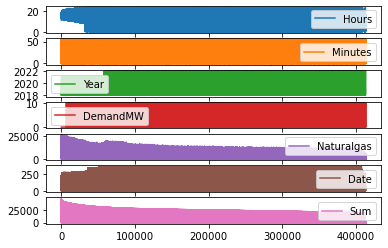

In [77]:
axes = final_df.plot.line(subplots=True)

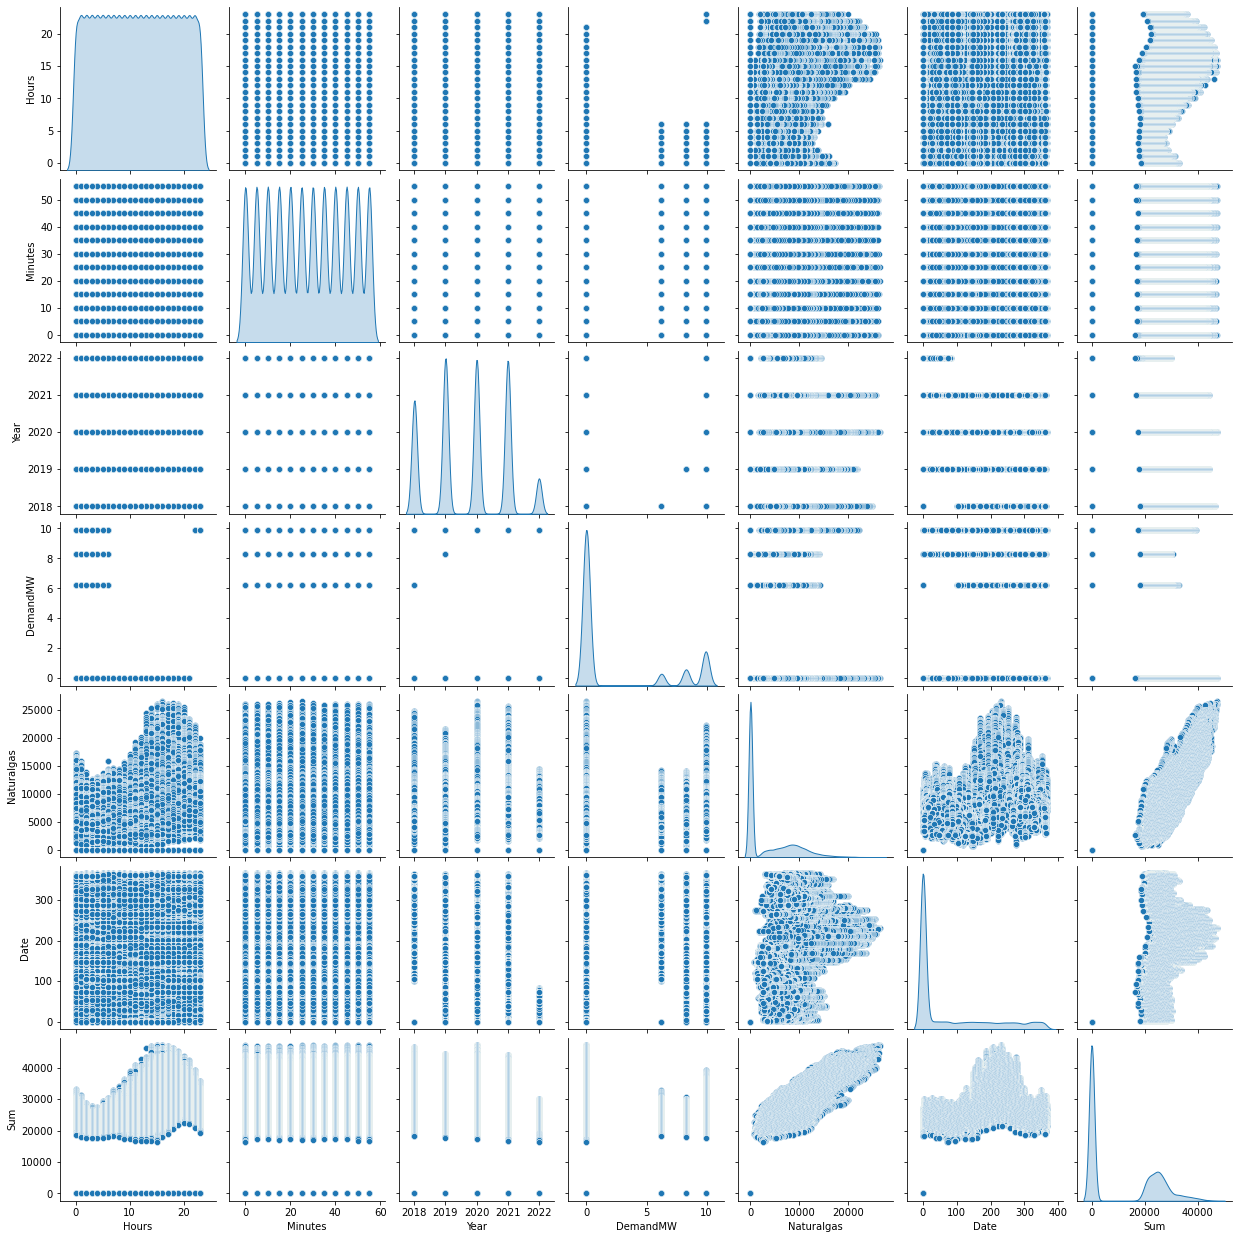

In [78]:
import seaborn as sns
sns.pairplot(data=final_df, diag_kind='kde')

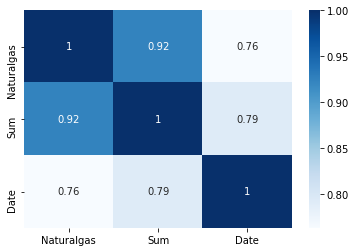

In [79]:
sns.heatmap(final_df[['Naturalgas','Sum', 'Date']].corr(), cmap='Blues', annot=True)
plt.show()

In [80]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median', missing_values=np.nan)
imputer = imputer.fit(final_df[['Naturalgas','Sum']])
final_df[['Naturalgas','Sum']] = imputer.transform(final_df[['Naturalgas','Sum']])
final_df

,Hours,Minutes,Year,DemandMW,Naturalgas,Date,Month-D.A,Day-DA,DateAttribute,Sum
0,11,50,2021,0.0,0.0,0,0,0,0,0.0
1,16,25,2020,0.0,26540.0,231,8,18,818,47279.0
2,15,55,2020,0.0,26159.0,231,8,18,818,47243.0
3,15,50,2020,0.0,26132.0,231,8,18,818,47210.0
4,15,40,2020,0.0,26015.0,231,8,18,818,47209.0
...,...,...,...,...,...,...,...,...,...,...
412947,2,35,2022,0.0,0.0,73,3,14,314,0.0
412948,2,40,2022,0.0,0.0,73,3,14,314,0.0
412949,2,45,2022,0.0,0.0,73,3,14,314,0.0
412950,2,50,2022,0.0,0.0,73,3,14,314,0.0


In [81]:
final_df= final_df.drop(['Year', 'DemandMW', 'Month-D.A', 'Day-DA', 'DateAttribute'],1)

In [82]:
print([final_df < 0] == True)

False


In [83]:
# Create our features
X = final_df.drop("Naturalgas", axis = 1)

# Create our target
y = final_df.loc[:, 'Naturalgas'].copy()

In [84]:
final_df.isnull().values.any()

False

In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [86]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [87]:
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)
print(model.predict(X_train))


[ -282.4809442  12899.36163549  9214.84247035 ...   348.83983489
  -346.67091061  -339.02024791]


In [88]:
print(training_score)

0.8594156478798176


In [89]:
print(testing_score)

0.8584630387457536


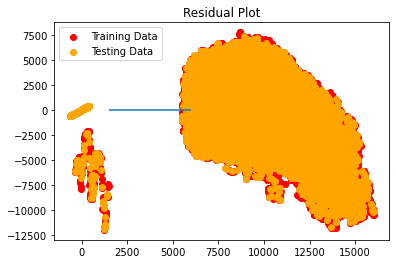

In [90]:
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="red", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=6000, xmax=1500)
plt.title("Residual Plot")
plt.show()

In [91]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Fitting our model with all our features in X
model.fit(X, y)
score = model.score(X, y)
print(f"R2 Score: {score}")

R2 Score: 0.859225166522545


Predicting Future Natural Gas Demand

In [2]:
# SQLAlchemy connection
cnx = create_engine('sqlite:///db-carenewable.db').connect()
df2030 = pd.read_sql_table('CAISO-ALL-SUPPLY-DATA', cnx)
ev_avg_df = pd.read_sql_table('AVERAGE-DEMAND-2020', cnx)

# Close SQLAlchemy connection
cnx.close()


In [3]:
df2030[df2030['Renewables'] < 0] = 0
df2030[df2030['Naturalgas'] < 0] = 0
df2030[df2030['Largehydro'] < 0] = 0
df2030[df2030['Imports'] < 0] = 0
df2030[df2030['Batteries'] < 0] = 0
df2030[df2030['Nuclear'] < 0] = 0
df2030[df2030['Coal'] < 0] = 0
df2030[df2030['Other'] < 0] = 0

In [4]:
df2030['Sum'] = df2030['Renewables'] + df2030['Largehydro'] + df2030['Imports'] + df2030['Batteries'] + df2030['Nuclear'] + df2030['Coal'] + df2030['Other'] + df2030['Naturalgas']

In [5]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median', missing_values=np.nan)
imputer = imputer.fit(df2030[['Naturalgas','Sum']])
df2030[['Naturalgas','Sum']] = imputer.transform(df2030[['Naturalgas','Sum']])
df2030

,Renewables,Naturalgas,Largehydro,Imports,Batteries,Nuclear,Coal,Other,Date,Time,DateTime,Sum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0
1,8695.0,26540.0,5081.0,4575.0,119.0,2248.0,21.0,0.0,8/18/20,16:25:00,8/18/20 16:25,47279.0
2,9301.0,26159.0,4408.0,5035.0,67.0,2250.0,23.0,0.0,8/18/20,15:55:00,8/18/20 15:55,47243.0
3,9343.0,26132.0,4382.0,5032.0,49.0,2250.0,22.0,0.0,8/18/20,15:50:00,8/18/20 15:50,47210.0
4,9283.0,26015.0,4300.0,5278.0,63.0,2248.0,22.0,0.0,8/18/20,15:40:00,8/18/20 15:40,47209.0
...,...,...,...,...,...,...,...,...,...,...,...,...
412947,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3/14/22,2:35:00,3/14/22 2:35,0.0
412948,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3/14/22,2:40:00,3/14/22 2:40,0.0
412949,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3/14/22,2:45:00,3/14/22 2:45,0.0
412950,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3/14/22,2:50:00,3/14/22 2:50,0.0


In [6]:
other_df = df2030['Time'].str.split(":", expand=True)
print(other_df)

          0    1    2
0       NaN  NaN  NaN
1        16   25   00
2        15   55   00
3        15   50   00
4        15   40   00
...     ...  ...  ...
412947    2   35   00
412948    2   40   00
412949    2   45   00
412950    2   50   00
412951    2   55   00

[412952 rows x 3 columns]


In [7]:
other_df.dropna(inplace=True)

In [8]:
#Format the baby_df into int.
other_df[0] = other_df[0].astype(int)
other_df[1] = other_df[1].astype(int)
#Clean baby_df
other_df= other_df.drop([2],1)

In [9]:
# Rename columns and create years value for calculating demand_EV
other_df = other_df.rename(columns={other_df.columns[0]: 'Hours'})
other_df = other_df.rename(columns={other_df.columns[1]: 'Minutes'})
other_df

,Hours,Minutes
1,16,25
2,15,55
3,15,50
4,15,40
5,16,55
...,...,...
412947,2,35
412948,2,40
412949,2,45
412950,2,50


In [10]:
df2030['Date'] = pd.to_datetime(df2030['Date'])

#Create a new column for'Year'
other_df['Year'] = df2030['Date'].dt.year
#Convert to integers to be used in computations
other_df['Year'] = other_df['Year'].astype(int)

other_df.head(100)

,Hours,Minutes,Year
1,16,25,2020
2,15,55,2020
3,15,50,2020
4,15,40,2020
5,16,55,2020
...,...,...,...
129,17,20,2020
130,17,20,2020
131,16,35,2018
134,17,35,2020


In [11]:
date_df = pd.DataFrame()
df2030['Date1']=df2030['Date'].astype(str)

date_df = df2030['Date1'].str.split("-", expand=True)
date_df['DateAttribute'] = date_df[1] + date_df[2]
date_df = date_df.drop([0,1,2],1)

def fun(datetimething):
     return datetimething.timetuple().tm_yday

In [13]:
def fun(datetimething):
     return datetimething.timetuple().tm_yday
    
df2030['Date'] = df2030['Date'].apply(fun)
df2030.head(1300)

,Renewables,Naturalgas,Largehydro,Imports,Batteries,Nuclear,Coal,Other,Date,Time,DateTime,Sum,Date1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0.0,1970-01-01
1,8695.0,26540.0,5081.0,4575.0,119.0,2248.0,21.0,0.0,231,16:25:00,8/18/20 16:25,47279.0,2020-08-18
2,9301.0,26159.0,4408.0,5035.0,67.0,2250.0,23.0,0.0,231,15:55:00,8/18/20 15:55,47243.0,2020-08-18
3,9343.0,26132.0,4382.0,5032.0,49.0,2250.0,22.0,0.0,231,15:50:00,8/18/20 15:50,47210.0,2020-08-18
4,9283.0,26015.0,4300.0,5278.0,63.0,2248.0,22.0,0.0,231,15:40:00,8/18/20 15:40,47209.0,2020-08-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0.0,1970-01-01
1296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0.0,1970-01-01
1297,5842.0,24279.0,4693.0,5863.0,144.0,2244.0,22.0,0.0,232,19:15:00,8/19/20 19:15,43087.0,2020-08-19
1298,5842.0,24279.0,4693.0,5863.0,144.0,2244.0,22.0,0.0,233,19:15:00,8/20/20 19:15,43087.0,2020-08-20


In [14]:
df2030 = df2030.drop(['Date'],1)
df2030['DateTime'] = pd.to_datetime(df2030['DateTime'])

In [17]:
date_df.head()

,DateAttribute
0,0101
1,0818
2,0818
3,0818
4,0818


In [18]:
poo_df = pd.merge(df2030, date_df, left_index=True, right_index=True, how='outer')

In [19]:
poo_df.head()

,Renewables,Naturalgas,Largehydro,Imports,Batteries,Nuclear,Coal,Other,Time,DateTime,Sum,Date1,DateAttribute
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1970-01-01 00:00:00,0.0,1970-01-01,0101
1,8695.0,26540.0,5081.0,4575.0,119.0,2248.0,21.0,0.0,16:25:00,2020-08-18 16:25:00,47279.0,2020-08-18,0818
2,9301.0,26159.0,4408.0,5035.0,67.0,2250.0,23.0,0.0,15:55:00,2020-08-18 15:55:00,47243.0,2020-08-18,0818
3,9343.0,26132.0,4382.0,5032.0,49.0,2250.0,22.0,0.0,15:50:00,2020-08-18 15:50:00,47210.0,2020-08-18,0818
4,9283.0,26015.0,4300.0,5278.0,63.0,2248.0,22.0,0.0,15:40:00,2020-08-18 15:40:00,47209.0,2020-08-18,0818


In [28]:
df1= pd.DataFrame()
df1 = poo_df.groupby(['DateAttribute','Time'])['Sum'].agg('mean')
df1 = df1.reset_index()
df1 = df1.rename(columns={df1.columns[2]: 'AvgSUM(3yr)'}).round(2)
df2 = df1.copy

print(len(df1))
df1.dtypes


88971


DateAttribute     object
Time              object
AvgSUM(3yr)      float64
dtype: object

In [31]:
df1.head()

,DateAttribute,Time,AvgSUM(3yr),Date1,pDateTime
0,0101,0,0.00,20200101,20200101 0
1,0101,0:00:00,22546.00,20200101,20200101 0:00:00
2,0101,0:05:00,23325.00,20200101,20200101 0:05:00
3,0101,0:10:00,22940.33,20200101,20200101 0:10:00
4,0101,0:15:00,22886.00,20200101,20200101 0:15:00


In [41]:
df1.drop(df1[df1['Time'] == 0].index, inplace = True)
df1.head()

,DateAttribute,Time,AvgSUM(3yr),Date1,pDateTime
1,0101,0:00:00,22546.00,20200101,20200101 0:00:00
2,0101,0:05:00,23325.00,20200101,20200101 0:05:00
3,0101,0:10:00,22940.33,20200101,20200101 0:10:00
4,0101,0:15:00,22886.00,20200101,20200101 0:15:00
5,0101,0:20:00,22822.33,20200101,20200101 0:20:00


In [42]:
df1['Date1']= "2020" + df1['DateAttribute']
df1['pDateTime'] = df1['Date1'] +" " +df1['Time'].astype(str)
df1['Date2']= pd.to_datetime(df1['pDateTime'])
df1=df1.set_index('Date2')       
                                            
df1=df1.sort_index(ascending=True)
df1=df1.reset_index()
ev_df2=df1.drop(['DateAttribute','Date1','pDateTime','Time'],1)



In [43]:
df1 = df1.drop(df1.index[16992:17280])
df1 = df1.reset_index(drop=True)
print(len(df1))
df1

88682


,Date2,DateAttribute,Time,AvgSUM(3yr),Date1,pDateTime
0,2020-01-01 00:00:00,0101,0:00:00,22546.00,20200101,20200101 0:00:00
1,2020-01-01 00:05:00,0101,0:05:00,23325.00,20200101,20200101 0:05:00
2,2020-01-01 00:10:00,0101,0:10:00,22940.33,20200101,20200101 0:10:00
3,2020-01-01 00:15:00,0101,0:15:00,22886.00,20200101,20200101 0:15:00
4,2020-01-01 00:20:00,0101,0:20:00,22822.33,20200101,20200101 0:20:00
...,...,...,...,...,...,...
88677,2020-12-31 23:35:00,1231,23:35:00,22745.33,20201231,20201231 23:35:00
88678,2020-12-31 23:40:00,1231,23:40:00,22671.00,20201231,20201231 23:40:00
88679,2020-12-31 23:45:00,1231,23:45:00,22602.33,20201231,20201231 23:45:00
88680,2020-12-31 23:50:00,1231,23:50:00,22520.00,20201231,20201231 23:50:00


In [44]:
df1= df1.drop(['DateAttribute', 'Date1', 'pDateTime'],1)
df1.head(1000)

,Date2,Time,AvgSUM(3yr)
0,2020-01-01 00:00:00,0:00:00,22546.00
1,2020-01-01 00:05:00,0:05:00,23325.00
2,2020-01-01 00:10:00,0:10:00,22940.33
3,2020-01-01 00:15:00,0:15:00,22886.00
4,2020-01-01 00:20:00,0:20:00,22822.33
...,...,...,...
995,2020-01-04 22:35:00,22:35:00,24950.50
996,2020-01-04 22:40:00,22:40:00,25671.00
997,2020-01-04 22:45:00,22:45:00,24127.00
998,2020-01-04 22:50:00,22:50:00,24010.00


In [45]:
time_df = df1['Time'].str.split(":", expand=True)
time_df.head()

,0,1,2
0,0,00,00
1,0,05,00
2,0,10,00
3,0,15,00
4,0,20,00


In [46]:
#Format the baby_df into int.
time_df[0] = time_df[0].astype(int)
time_df[1] = time_df[1].astype(int)


# Rename columns and create years value for calculating demand_EV
time_df = time_df.rename(columns={time_df.columns[0]: 'Hours'})
time_df = time_df.rename(columns={time_df.columns[1]: 'Minutes'})


In [47]:
final_demand_df = pd.merge(time_df, df1, left_index=True, right_index=True, how='outer')
final_demand_df.head()

,Hours,Minutes,2,Date2,Time,AvgSUM(3yr)
0,0,0,00,2020-01-01 00:00:00,0:00:00,22546.00
1,0,5,00,2020-01-01 00:05:00,0:05:00,23325.00
2,0,10,00,2020-01-01 00:10:00,0:10:00,22940.33
3,0,15,00,2020-01-01 00:15:00,0:15:00,22886.00
4,0,20,00,2020-01-01 00:20:00,0:20:00,22822.33


In [48]:
def fun(datetimething):
     return datetimething.timetuple().tm_yday

In [49]:
final_demand_df['Date2'] = final_demand_df['Date2'].apply(fun)

In [50]:
final_demand_df= final_demand_df.drop(['Time', 2],1)
df1.head(1000)

,Date2,Time,AvgSUM(3yr)
0,2020-01-01 00:00:00,0:00:00,22546.00
1,2020-01-01 00:05:00,0:05:00,23325.00
2,2020-01-01 00:10:00,0:10:00,22940.33
3,2020-01-01 00:15:00,0:15:00,22886.00
4,2020-01-01 00:20:00,0:20:00,22822.33
...,...,...,...
995,2020-01-04 22:35:00,22:35:00,24950.50
996,2020-01-04 22:40:00,22:40:00,25671.00
997,2020-01-04 22:45:00,22:45:00,24127.00
998,2020-01-04 22:50:00,22:50:00,24010.00


In [51]:
final_demand_df.head(1000)

,Hours,Minutes,Date2,AvgSUM(3yr)
0,0,0,1,22546.00
1,0,5,1,23325.00
2,0,10,1,22940.33
3,0,15,1,22886.00
4,0,20,1,22822.33
...,...,...,...,...
995,22,35,4,24950.50
996,22,40,4,25671.00
997,22,45,4,24127.00
998,22,50,4,24010.00


In [52]:
final_demand_df = final_demand_df.rename(columns={'Date2': 'Day', 'AvgSUM(3yr)': 'AvgSum'})

In [53]:
final_demand_df.head()

,Hours,Minutes,Day,AvgSum
0,0,0,1,22546.00
1,0,5,1,23325.00
2,0,10,1,22940.33
3,0,15,1,22886.00
4,0,20,1,22822.33


In [54]:
len(final_demand_df)

88682

In [55]:
mask = (final_demand_df['Hours'] < 7) | (final_demand_df['Hours'] > 21)
final_demand_df.loc[mask, 'AvgSum'] += 106.68

In [56]:
final_demand_df.head(5000)

,Hours,Minutes,Day,AvgSum
0,0,0,1,22652.68
1,0,5,1,23431.68
2,0,10,1,23047.01
3,0,15,1,22992.68
4,0,20,1,22929.01
...,...,...,...,...
4995,16,35,20,24649.00
4996,16,40,20,24799.75
4997,16,45,20,24953.25
4998,16,50,20,25115.25


In [92]:
print(len(final_demand_df.loc[final_demand_df['AvgSum'] < 0]))
print(final_demand_df['AvgSum'].mean())
print(final_df['Sum'].mean())


0
25691.73318362398
11355.35920397528


In [93]:
final_demand_df.head()

,Hours,Minutes,Day,AvgSum
0,0,0,1,22652.68
1,0,5,1,23431.68
2,0,10,1,23047.01
3,0,15,1,22992.68
4,0,20,1,22929.01


In [94]:
final_demand_df['Predicted 2030 NatGas'] = model.predict(final_demand_df)

In [95]:
len(final_demand_df)

88682

In [96]:
df2030.head()

,Renewables,Naturalgas,Largehydro,Imports,Batteries,Nuclear,Coal,Other,Time,DateTime,Sum,Date1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1970-01-01 00:00:00,0.0,1970-01-01
1,8695.0,26540.0,5081.0,4575.0,119.0,2248.0,21.0,0.0,16:25:00,2020-08-18 16:25:00,47279.0,2020-08-18
2,9301.0,26159.0,4408.0,5035.0,67.0,2250.0,23.0,0.0,15:55:00,2020-08-18 15:55:00,47243.0,2020-08-18
3,9343.0,26132.0,4382.0,5032.0,49.0,2250.0,22.0,0.0,15:50:00,2020-08-18 15:50:00,47210.0,2020-08-18
4,9283.0,26015.0,4300.0,5278.0,63.0,2248.0,22.0,0.0,15:40:00,2020-08-18 15:40:00,47209.0,2020-08-18


In [109]:
final_df.head()
print(final_df['Naturalgas'].mean())

3788.648453088979


In [110]:
l = final_df["Naturalgas"].mean()
p = final_demand_df["Predicted 2030 NatGas"].mean()
print((((p/l)-1))*100)

132.22589305565185


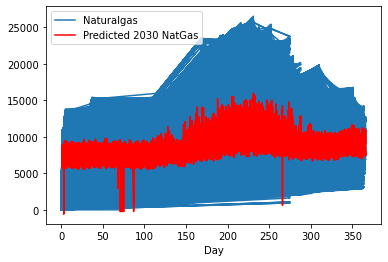

In [115]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
# gca stands for 'get current axis'
ax = plt.gca()

final_df.plot(kind='line',x='Date',y='Naturalgas',ax=ax)
final_demand_df.plot(kind='line',x='Day',y='Predicted 2030 NatGas', color='red', ax=ax)
    
    # adjust the y axis scale.
#ax.locator_params('y', nbins=5)
    # adjust the x axis scale.
#plt.locator_params('x', nbins=20)
    # show the final figure.
plt.show()  
